# Convolutional Neural Net
In this notebook we will build a convolutional neural net (CNN) to classify handwritten numbers.
To do this we will use the mnist data set.

CNNs exploit spatially-local correlation by enforcing a local connectivity pattern between neurons of adjacent layers. This is like the retina, but in a computer.

In [51]:
import theano
import theano.tensor as T
import lasagne
import numpy as np

# import sklearn.datasets
from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt

%matplotlib inline
import IPython.display
from time import sleep

Import the data loader from mnist.py

In [36]:
from mnist import load_dataset

Load the training, validation and test data

In [37]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()
# Create a dataset dictionary for convenience
dataset = {
    'train': {'X': X_train, 'y': y_train},
    'valid': {'X': X_valid, 'y': y_valid}}

This data set has 50000 examples for training. 
X_train is (50000, 1, 28, 28) and contains the 50000 images, each of which is gray scale (n_channels = 1) and 28x28 pixels.
y_train is 50000, is a vector of numbers from 0-9 that are the labels.

Plot an example digit with its label

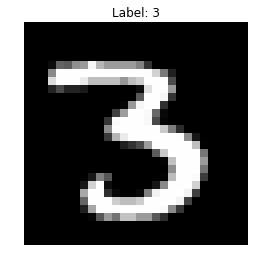

In [39]:
plt.imshow(dataset['train']['X'][12][0], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(dataset['train']['y'][12]))
plt.gca().set_axis_off()

# Build the neural net
Input layer has the shape of the data
## Convolution Layer
The basic 2D convolutional layer in Lasagne is Conv2DLayer. The layer works by convolution of the input layer with a linear filter adding a bias term and then applying a non-linear function.
This generates a feature map
We are using 32 learnable convolutional filters for this layer. Each layer has a 5x5 receptor field. 
## MaxPooling
Max-pooling partitions the input image into a set of non-overlapping rectangles and, for each such sub-region, outputs the maximum value.

In [67]:
input_shape = dataset['train']['X'][0].shape
# input layer
l_in = lasagne.layers.InputLayer(shape=(None, input_shape[0], input_shape[1], input_shape[2]))
# First convolutional layer
l_conv1 = lasagne.layers.Conv2DLayer(l_in,
    # Here, we set the number of filters and their size.
    num_filters=32, 
    filter_size=(8, 8),
    nonlinearity=lasagne.nonlinearities.rectify,
    # Use He et. al.'s initialization
    W=lasagne.init.HeNormal(gain='relu'))
# Pool the layer with 2x2 Max pooling. Lasagne has the option to do mean pooling as well.
l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1,pool_size=(2, 2))
# The second convolution/pooling pair is the same as above.
l_conv2 = lasagne.layers.Conv2DLayer(
    l_pool1, num_filters=32, filter_size=(8, 8),
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))
l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))
# First hidden layer
l_hidden1 = lasagne.layers.DenseLayer(
    l_pool2, 
    # Why is the num_unit = 256 here? Seems arbitray.
    num_units=196, 
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))
# Add a dropout layer to pervent over classification
l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.2)
# Output layer. num of units = 10 because y can take a value from 0-9
l_output = lasagne.layers.DenseLayer(
    l_hidden1_dropout,
    # The number of units in the softmas output layer is the number of classes.
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

In [68]:
net_output = lasagne.layers.get_output(l_output)

## Prepare training
We define a loss function loss. As before, and is typical we are using the categorical crossentropy.
For updates we will use Adaptive Learning Rate method for the Stocahstic Gradient Desent.

In [69]:
true_output = T.ivector('true_output')
loss = T.mean(lasagne.objectives.categorical_crossentropy(net_output, true_output))

all_params = lasagne.layers.get_all_params(l_output)
# Use ADADELTA for updates
updates = lasagne.updates.adadelta(loss, all_params)
train = theano.function([l_in.input_var, true_output], loss, updates=updates)

# This is the function we'll use to compute the network's output given an input
# (e.g., for computing accuracy).  Again, we don't want to apply dropout here
# so we set the deterministic kwarg to True.
get_output = theano.function([l_in.input_var],
                             lasagne.layers.get_output(l_output, deterministic=True))

# Training
We will chop the training data into mini-batches, and compute the validation accuracy every epoch.

In [70]:
BATCH_SIZE = 500
N_EPOCHS = 5
# Keep track of which batch we're training with
batch_idx = 0
# Keep track of which epoch we're on
epoch = 0
while epoch < N_EPOCHS:
    # Extract the training data/label batch and update the parameters with it
    train(dataset['train']['X'][batch_idx:batch_idx + BATCH_SIZE],
          dataset['train']['y'][batch_idx:batch_idx + BATCH_SIZE])
    batch_idx += BATCH_SIZE
    print("Batch {}, ".format(batch_idx/BATCH_SIZE),end="")
    # Once we've trained on the entire training set...
    if batch_idx >= dataset['train']['X'].shape[0]:
        # Reset the batch index
        batch_idx = 0
        # Update the number of epochs trained
        epoch += 1
        # Compute the network's output on the validation data
        val_output = get_output(dataset['valid']['X'])
        # The predicted class is just the index of the largest probability in the output
        val_predictions = np.argmax(val_output, axis=1)
        # The accuracy is the average number of correct predictions
        accuracy = np.mean(val_predictions == dataset['valid']['y'])
        print("Epoch {} validation accuracy: {}".format(epoch, accuracy))

Batch 1, Batch 2, Batch 3, Batch 4, Batch 5, Batch 6, Batch 7, Batch 8, Batch 9, Batch 10, Batch 11, Batch 12, Batch 13, Batch 14, Batch 15, Batch 16, Batch 17, Batch 18, Batch 19, Batch 20, Batch 21, Batch 22, Batch 23, Batch 24, Batch 25, Batch 26, Batch 27, Batch 28, Batch 29, Batch 30, Batch 31, Batch 32, Batch 33, Batch 34, Batch 35, Batch 36, Batch 37, Batch 38, Batch 39, Batch 40, Batch 41, Batch 42, Batch 43, Batch 44, Batch 45, Batch 46, Batch 47, Batch 48, Batch 49, Batch 50, Batch 51, Batch 52, Batch 53, Batch 54, Batch 55, Batch 56, Batch 57, Batch 58, Batch 59, Batch 60, Batch 61, Batch 62, Batch 63, Batch 64, Batch 65, Batch 66, Batch 67, Batch 68, Batch 69, Batch 70, Batch 71, Batch 72, Batch 73, Batch 74, Batch 75, Batch 76, Batch 77, Batch 78, Batch 79, Batch 80, Batch 81, Batch 82, Batch 83, Batch 84, Batch 85, Batch 86, Batch 87, Batch 88, Batch 89, Batch 90, Batch 91, Batch 92, Batch 93, Batch 94, Batch 95, Batch 96, Batch 97, Batch 98, Batch 99, Batch 100, Epoch 1 